# PyMC3 with NetworkX for BayesNets

In [1]:
## For debbugging
%load_ext autoreload

%aimport pmml.bn
%aimport pymcnet.net
%aimport pymcnet.expr_parse
%autoreload 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# from networkx.drawing.nx_pydot import graphviz_layout,write_dot # pygraphviz
%matplotlib inline


In [3]:
# import multiprocessing
import pymc3 as pm
import networkx as nx

## Helper Functions

In [4]:
from pymcnet.net import *

## Model 1 (lin. Regression)

In [5]:
# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

In [6]:
D = BayesianNetwork()
# root nodes can be defined staticly. 
D.add_node('alpha', mu=0, sd=10, dist_type='Normal')
D.add_node('beta', mu=0, sd=10, shape=2, dist_type='Normal')
D.add_node('sigma', sd=1, dist_type='HalfNormal')

# inheriting nodes need to have functions as attributes to be called at runtime. 
# You can reference the RV's associated with other nodes using BayesianNetwork().d(othernode)
D.add_node('Y_obs', 
           mu = lambda: D.d('alpha')+\
           D.d('beta')[0]*X1+\
           D.d('beta')[1]*X2,
           sd = lambda: D.d('sigma'),
#            exprs = {'mu':'alpha + beta*X2 + beta*X1',
#                     'sd': 'sigma'},
           observed=Y,
           dist_type='Normal')
D.add_edges_from([('alpha','Y_obs'),('beta','Y_obs')], var='mu')
D.add_edges_from([('sigma','Y_obs')], var='sd')
# [i for i in nx.ancestors(D, 'Y_obs') if D.edge[i]['Y_obs']['var']=='sd']

/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


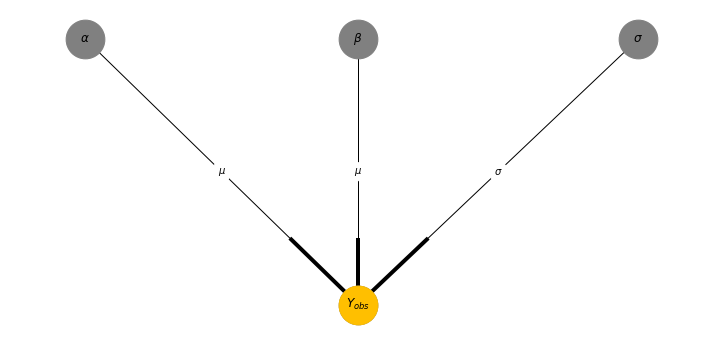

['alpha', 'beta', 'sigma', 'Y_obs']

In [7]:
draw_net(D, pretty=True)
D.nodes()

In [8]:
with pm.Model() as model:
    instantiate_pm(D)

alpha
root node; keys:  ['mu', 'sd']
beta
root node; keys:  ['mu', 'shape', 'sd']
sigma
root node; keys:  ['sd']
Y_obs
child node; keys:  ['observed', 'mu', 'sd']


In [22]:
with model:
#     step = pm.Metropolis()
    trace = pm.sample(1000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 156.07:   5%|▌         | 10966/200000 [00:01<00:20, 9163.71it/s]
Convergence archived at 11100
Interrupted at 11,100 [5%]: Average Loss = 237.04
100%|██████████| 1500/1500 [00:01<00:00, 1193.73it/s]


(4000,)

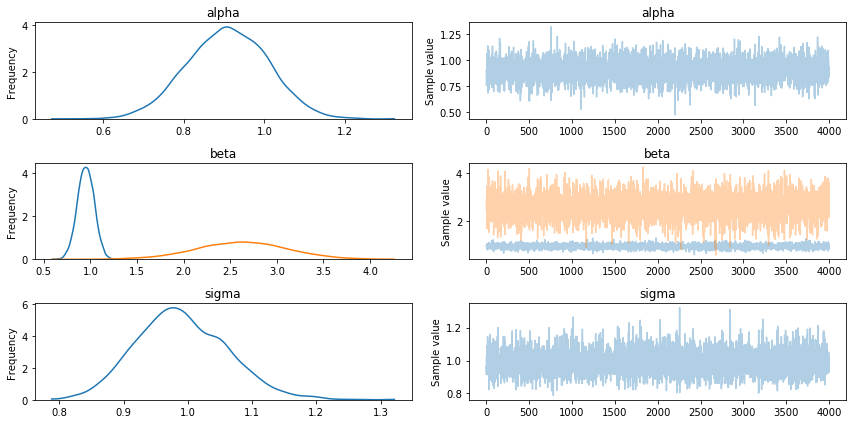

In [23]:
pm.traceplot(trace, combined=True);
trace.get_values('alpha').shape

`![pymc3_net](pymc3.png)`

## Model 2: Coal-mining Switchpoint

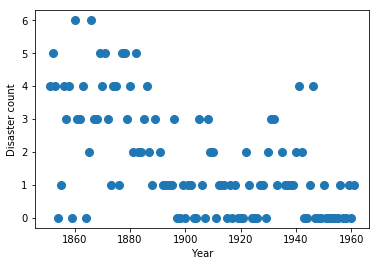

In [24]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
year = np.arange(1851, 1962)

plt.plot(year, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year")

In [25]:
D = BayesianNetwork()
# root nodes can be defined staticly. 
D.add_node('switchpoint', 
           lower=year.min(),
           upper=year.max(), 
           dist_type='DiscreteUniform', 
           testval=1900)

D.add_node('early_rate', lam=1., dist_type='Exponential')
D.add_node('late_rate', lam=1., dist_type='Exponential')

# make sure to assume strings as input (node names) and use
# node dist as the vars
rate = lambda: pm.math.switch(1*(D.d('switchpoint') >= year), 
                                      D.d('early_rate'), 
                                      D.d('late_rate'))

# inheriting nodes need to have functions as attributes 
# to be called at runtime. 

D.add_node('disasters', 
           mu = rate,
           observed=disaster_data,
          dist_type='Poisson')

           
D.add_edges_from([('late_rate','disasters'),
                  ('early_rate','disasters'),
                  ('switchpoint','disasters')], var='mu')

In [26]:
D.predecessors('disasters')[::-1]

['switchpoint', 'early_rate', 'late_rate']

/home/tbsexton/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


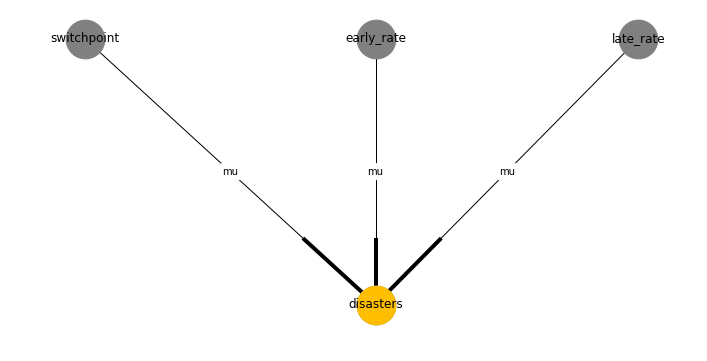

In [27]:
draw_net(D)

In [28]:
with pm.Model() as model:
    instantiate_pm(D)

switchpoint
root node; keys:  ['upper', 'lower', 'testval']
early_rate
root node; keys:  ['lam']
late_rate
root node; keys:  ['lam']
disasters
child node; keys:  ['observed', 'mu']


In [33]:
with model:
#     step = pm.Metropolis()
    trace = pm.sample(1000, njobs=2)
    
    

Assigned Metropolis to switchpoint
Assigned NUTS to early_rate_log__
Assigned NUTS to late_rate_log__
Assigned Metropolis to disasters_missing
Process ForkPoolWorker-49:
Process ForkPoolWorker-50:
Process ForkPoolWorker-51:
Process ForkPoolWorker-52:
Traceback (most recent call last):
  File "/home/tbsexton/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/tbsexton/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/tbsexton/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/tbsexton/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/tbsexton/anaconda3/lib/python3.6/site-packages/joblib/pool.py", line 362, in get
    return recv()
  File "/home/tbsexton/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in 

KeyboardInterrupt: 

ValueError: zero-size array to reduction operation minimum which has no identity

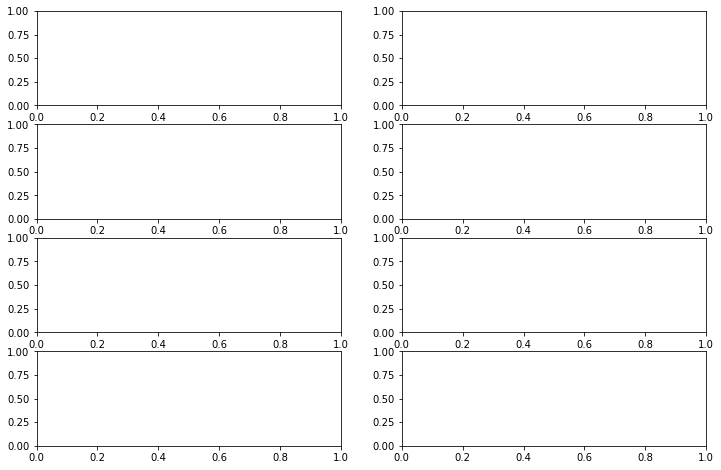

In [31]:
pm.traceplot(trace, combined=True);

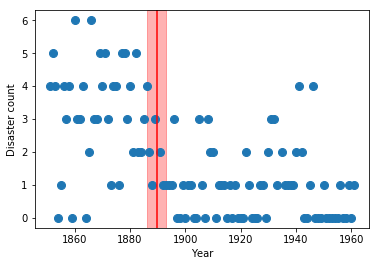

In [17]:
plt.plot(year, disaster_data, 'o', markersize=8);
data = trace[3000:].get_values('switchpoint')
plt.axvline(data.mean(), color='r')
plt.axvspan(np.percentile(data, 5), 
            np.percentile(data, 95), 
            alpha=.3, color='r')
plt.ylabel("Disaster count")
plt.xlabel("Year")


## Volatility

401


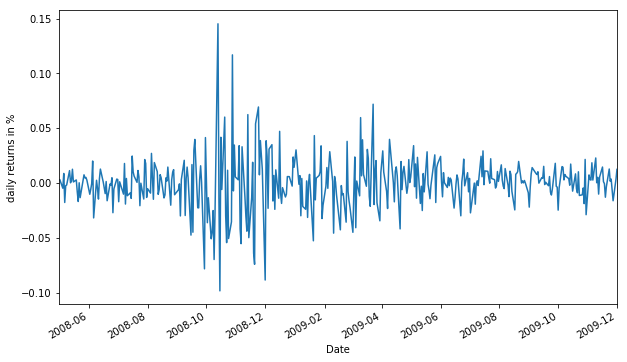

In [18]:
from pandas_datareader import data
import pandas as pd

returns = data.get_data_yahoo('SPY', start='2008-5-1', end='2009-12-1')['Adj Close'].pct_change()

print(len(returns))

returns.plot(figsize=(10, 6))
plt.ylabel('daily returns in %');

In [19]:
from pymc3.math import exp
from pymc3.distributions.timeseries import GaussianRandomWalk

D = BayesianNetwork()
D.add_node('nu',
           lam=1./10., testval=5.,
           dist_type='Exponential')
D.add_node('sigma', 
           lam=1./.02, testval=.1,
          dist_type='Exponential')
D.add_node('s',
           tau=lambda: D.d('sigma')**-2, 
           dist_type='GaussianRandomWalk', shape=len(returns))
D.add_edge('sigma', 's', var='tau')

D.add_node('volatility_process',
           var=lambda: exp(-2*D.d('s')), 
           dist_type='Deterministic')
D.add_edge('s', 'volatility_process', var='var')

D.add_node('r', 
           nu = lambda:D.d('nu'),
           lam = lambda: 1./D.d('volatility_process'), 
           observed = returns, dist_type='StudentT')
D.add_edge('nu', 'r', var='nu')
D.add_edge('volatility_process', 'r', var='lam')

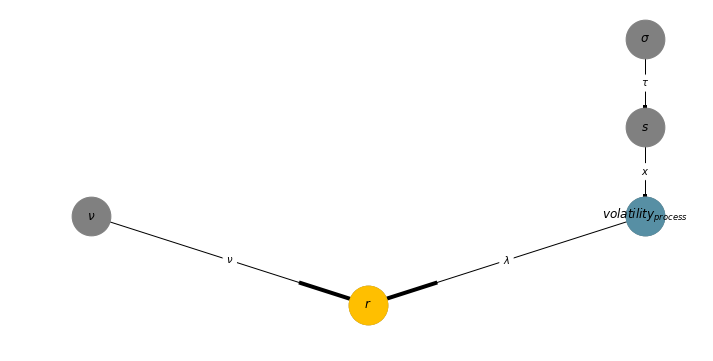

In [20]:
draw_net(D, pretty=True)

In [21]:
with pm.Model() as model:
    instantiate_pm(D)

nu
root node; keys:  ['lam', 'testval']
sigma
root node; keys:  ['lam', 'testval']
s
child node; keys:  ['tau', 'shape']
volatility_process
child node; keys:  ['var']
r
child node; keys:  ['observed', 'lam', 'nu']


In [22]:
with model:
    trace=pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 883.23: 100%|█████████| 200000/200000 [00:48<00:00, 4082.55it/s]
Finished [100%]: Average ELBO = 883.26
100%|██████████████████████████████████████| 2000/2000 [02:09<00:00, 15.43it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000002CCFF080>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000013C426D8>]], dtype=object)

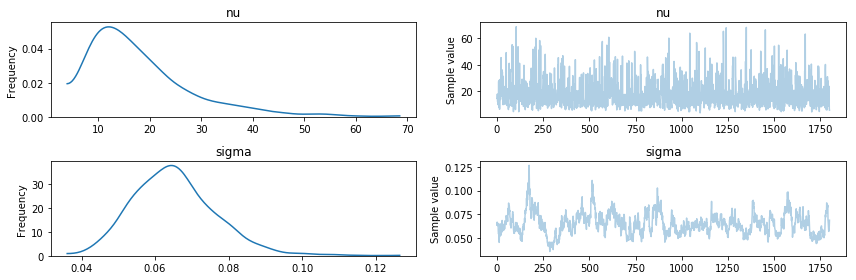

In [23]:
pm.traceplot(trace[200:], [D.d('nu'), D.d('sigma')])

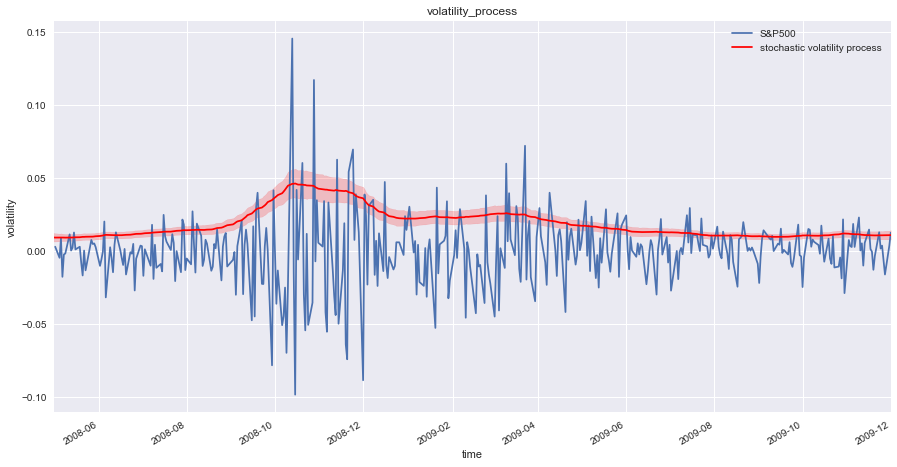

In [24]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
samps = pd.DataFrame(columns=['S.{}'.format(i) for i in range(1000)], 
                     data=1./np.exp(trace['s',::2]).T, index=returns.index)
# samps['date']=returns.index.values()
ax.plot(samps.index, samps.mean(axis=1), 'r');
ax.fill_between(samps.index, samps.quantile(.1,axis=1), 
                samps.quantile(.9,axis=1), color='r', alpha=0.2)
# sns.tsplot(samps, time='date')

ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process'])
# pd.DataFrame.quantile()

## Baseball Trajectory

If you have purely mathematical expressions as the node RV values, you can use the `exprs` attribute to define them. All node references are determined automatically, and math functions available in default `pymc3.math` or standard python can be used. Just beware, outside references to variables is not allowed (i.e. bayes-net must be self-contained. 

**`BEWARE`** The current implementation of this (designed for compatibility with PMML (XML) bayes-nets) utilizes a call to `eval()` python function. **Do not use this unless you can absolutely trust the string being used in `exprs`**

C:\Users\tbs4\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


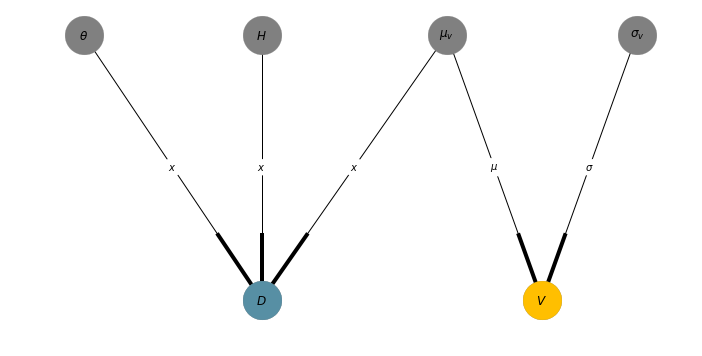

In [27]:
from pymc3.math import sin, cos, sqrt
from theano.tensor import mean

#synthetic test throws
np.random.seed(19806)  # random.org
v_obsv = np.random.normal(loc=28., scale=1., size=10.)  # m/s

# gravity
# g = 9.81  # m/s**2  # AHA! Cannot use this with exprs tag!

D = BayesianNetwork()
D.add_node('theta', 
           lower=np.pi/4.-.1, 
           upper=np.pi/4.+.1,
           dist_type='Uniform')  # close to 45deg
D.add_node('H', 
           lower=1.,
           upper=2.,
           dist_type='Uniform')  # about human-height

D.add_node('mu_v',
           lower=1., 
           upper=30.,
           dist_type='Uniform')  # from slow to best available
D.add_node('sd_v', 
           beta=5., 
           dist_type='HalfCauchy')  # something

D.add_node('V', 
#            mu=lambda: D.d('mu_v'), 
#            sd=lambda: D.d('sd_v'),
           exprs = {'mu': 'mu_v',
                    'sd': 'sd_v'},
           dist_type='Normal', 
           observed=v_obsv)

D.add_edge('mu_v', 'V', var='mu')
D.add_edge('sd_v', 'V', var='sd')

D.add_node('D', 
#            var=distance_f, 
           exprs = {'var': 'mu_v*cos(theta)*(mu_v*sin(theta) + sqrt((mu_v*sin(theta))**2+2*9.81*H)/9.81)'},
           dist_type='Deterministic')
D.add_edges_from([(i, 'D') for i in ['theta', 'H', 'mu_v']], var='var')

draw_net(D, pretty=True)

theta
root node; keys:  ['upper', 'lower']
H
root node; keys:  ['upper', 'lower']
mu_v
root node; keys:  ['upper', 'lower']
sd_v
root node; keys:  ['beta']
V
child node; keys:  ['observed', 'mu', 'sd']
D
child node; keys:  ['var']


100%|████████████████████████████████████| 5000/5000 [00:01<00:00, 2544.53it/s]


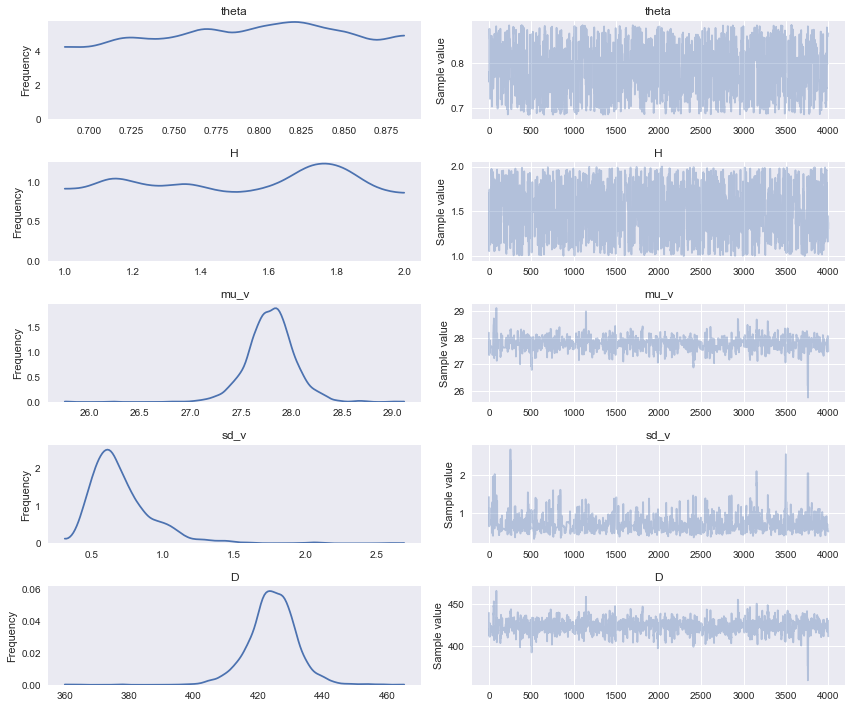

In [28]:
with pm.Model() as projectile_model:
    instantiate_pm(D, evaluate_exprs=True)

with projectile_model:
    step=pm.Metropolis()
    proj_trace=pm.sample(5000, step=step)
    
pm.traceplot(proj_trace[1000:]);
    